In [1]:
!pip3 install pandas

In [2]:
# Read In Data
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


goalies_df = pd.read_csv('/content/drive/My Drive/Goalies.csv', on_bad_lines="skip")
teams_df = pd.read_csv('/content/drive/My Drive/Teams.csv')

Mounted at /content/drive


In [3]:
# Merge datasets
merged_df = pd.merge(
    teams_df,
    goalies_df,
    on=['year', 'tmID'],
    how='inner'
)

# 1. Drop unnecessary columns
columns_to_drop = ['lgID_y', 'confID', 'divID', 'franchID', 'name',
                  'PostGP', 'PostMin', 'PostW', 'PostL', 'PostT', 'PostENG',
                  'PostSHO', 'PostGA', 'PostSA', 'playoff', 'rank', 'ENG',
                  'lgID_x', 'GA_y', 'W_x', 'L_x', 'T', 'OTL', 'W_y', 'L_y',
                  'T/OL', 'SoW', 'SoL']
cleaned_df = merged_df.drop(columns=columns_to_drop)

# 2. Rename columns for clarity
cleaned_df = cleaned_df.rename(columns={'GA_x': 'GA'})

# 3. Group by team and year to get team-level statistics
team_stats = cleaned_df.groupby(['year', 'tmID']).agg({
    'G': 'first',          # Games played by team
    'Pts': 'first',        # Team points
    'GF': 'first',         # Goals for
    'GA': 'first',         # Goals against
    'GP': 'sum',           # Total games played by goalies
    'Min': 'sum',          # Total minutes by goalies
    'SHO': 'sum',          # Total shutouts
    'SA': 'sum',           # Total shots against
    'PIM': 'first',        # Penalties in minutes
    'PPG': 'first',        # Power play goals
    'PPC': 'first',        # Power play chances
    'PKG': 'first',        # Penalty kill goals against
    'PKC': 'first'         # Penalty kill chances
}).reset_index()

# 4. Calculate additional metrics
team_stats['SavePercentage'] = (team_stats['SA'] - team_stats['GA']) / team_stats['SA']
team_stats['GoalsAgainstAvg'] = (team_stats['GA'] * 60) / team_stats['Min']

# 5. Handle missing/infinite values
team_stats = team_stats.replace([np.inf, -np.inf], np.nan)

# 6. Display summary statistics and check for missing values
print("\nDataset Shape:", team_stats.shape)
print("\nMissing Values:")
print(team_stats.isnull().sum())
print("\nSummary Statistics:")
print(team_stats.describe())

# Prepare features and target
features_to_drop = ['Pts', 'year', 'tmID']
X = team_stats.drop(columns=features_to_drop)
y = team_stats['Pts']

# Clean NaN and infinite values before modeling
print(f"\nOriginal number of rows: {len(X)}")

# 1. Remove rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan)
mask = ~X.isna().any(axis=1)  # Create mask of rows without NaN
X = X[mask]
y = y[mask]

print(f"Number of rows after removing NaN/infinite values: {len(X)}")
print(f"Removed {len(team_stats) - len(X)} rows")


Dataset Shape: (1519, 17)

Missing Values:
year                 0
tmID                 0
G                    0
Pts                  0
GF                   0
GA                   0
GP                   0
Min                  0
SHO                  0
SA                   0
PIM                110
PPG                418
PPC                419
PKG                418
PKC                419
SavePercentage     685
GoalsAgainstAvg      0
dtype: int64

Summary Statistics:
              year            G          Pts           GF           GA  \
count  1519.000000  1519.000000  1519.000000  1519.000000  1519.000000   
mean   1974.527979    69.518104    71.276498   218.764977   218.764977   
std      28.708711    19.699843    26.277603    77.905094    79.168426   
min    1909.000000     1.000000     0.000000     4.000000     8.000000   
25%    1957.000000    70.000000    54.000000   176.000000   173.500000   
50%    1981.000000    80.000000    75.000000   227.000000   228.000000   
75%    1998.0

In [5]:
import matplotlib.pyplot as plt
import time

start_time = time.time()
team_stats_wade = team_stats[['tmID', 'PPG', 'GF']].sort_values(by='GF', ascending=False)
end_time = time.time()
print(f"Query execution time: {end_time - start_time:.3f} seconds")
# Count Rows
print(f"Number of Rows: {len(team_stats_wade)}")
print(f"Number of Columns: {len(team_stats_wade.columns)}")

Query execution time: 0.009 seconds
Number of Rows: 1519
Number of Columns: 3


Outliers based on z-scores:
     tmID    PPG   GF  PPG_zscore  GF_zscore
795  EDM   81.0  446    1.100105   3.743776
837  EDM   78.0  426    0.918731   3.351658
774  EDM   86.0  424    1.402395   3.312447
754  EDM   86.0  417    1.402395   3.175206
984  DET  113.0  369    3.034761   2.234124
909  PIT  119.0  347    3.397509   1.802795
690  IND   16.0   78   -2.829665  -3.471181


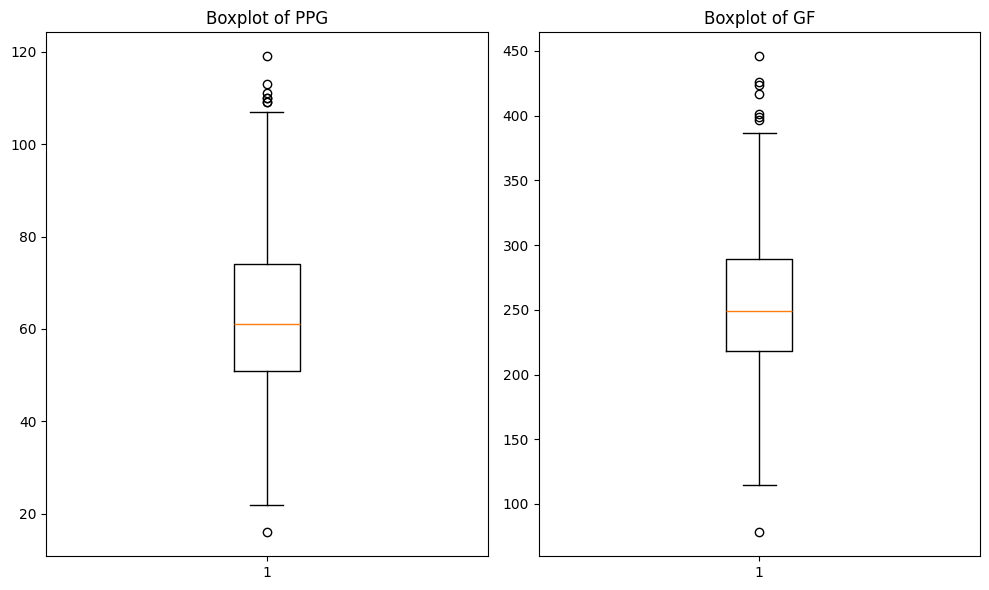

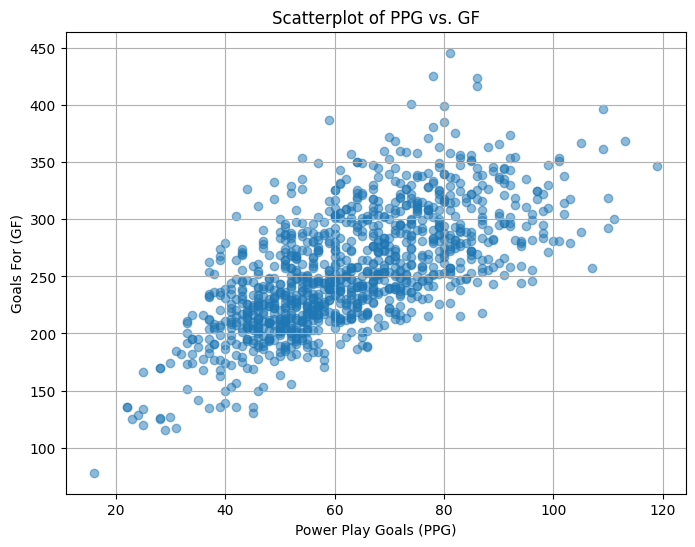

In [9]:
# Remove rows with null values in 'PPG' and 'GF' columns
team_stats_wade = team_stats_wade.dropna(subset=['PPG', 'GF'])

# Calculate the z-scores for 'PPG' and 'GF'
for col in ['PPG', 'GF']:
    team_stats_wade[col + '_zscore'] = (team_stats_wade[col] - team_stats_wade[col].mean()) / team_stats_wade[col].std()

# Define a threshold for outlier detection (e.g., 3 standard deviations)
threshold = 3

# Identify outliers based on z-scores
outliers_zscore = team_stats_wade[(np.abs(team_stats_wade['PPG_zscore']) > threshold) | (np.abs(team_stats_wade['GF_zscore']) > threshold)]

# Print the outliers
print("Outliers based on z-scores:\n", outliers_zscore)

# Create boxplots for 'PPG' and 'GF'
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.boxplot(team_stats_wade['PPG'])
plt.title('Boxplot of PPG')
plt.subplot(1, 2, 2)
plt.boxplot(team_stats_wade['GF'])
plt.title('Boxplot of GF')
plt.tight_layout()
plt.show()

# Create a scatterplot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(team_stats_wade['PPG'], team_stats_wade['GF'], alpha=0.5)  # alpha for transparency
plt.title('Scatterplot of PPG vs. GF')
plt.xlabel('Power Play Goals (PPG)')
plt.ylabel('Goals For (GF)')
plt.grid(True)  # Add gridlines for better readability
plt.show()

In [10]:
import statsmodels.formula.api as smf

# Define the regression model
model = smf.ols('GF ~ PPG', data=team_stats_wade)

# Fit the model
results = model.fit()

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     GF   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     851.9
Date:                Mon, 14 Apr 2025   Prob (F-statistic):          4.04e-139
Time:                        20:17:36   Log-Likelihood:                -5574.9
No. Observations:                1101   AIC:                         1.115e+04
Df Residuals:                    1099   BIC:                         1.116e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    127.0719      4.534     28.026      0.0

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Prepare the data
X = team_stats_wade[['PPG']]  # Independent variable
y = team_stats_wade['GF']    # Dependent variable

# Initialize the model
model = LinearRegression()

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds, shuffle data

# Perform cross-validation
mse_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions

    mse = mean_squared_error(y_test, y_pred)  # Calculate MSE
    mse_scores.append(mse)

# Print the cross-validation results
print(f"Mean Squared Error (MSE) scores: {mse_scores}")
print(f"Average MSE: {np.mean(mse_scores)}")

Mean Squared Error (MSE) scores: [1538.0332890139841, 1412.8809988748428, 1490.7440161319678, 1411.7643499593926, 1492.4234911437347]
Average MSE: 1469.1692290247843
